# DIABETIC RETINOPATHY - CNN
## Giacomo Deandrea, Giulio Quaglia
## a.a. 2019/2020
### Prova

La retinopatia diabetica è una malattia degli occhi che può occorrere ai diabetici.
Consiste nel danneggiamento della rete vascolare del tessuto della parte fotosensibile dell'occhio, la retina.

Questo notebook è stato utilizzato come prova iniziale utile soprattutto a prendere confidenza con il dataset e con le librerie utilizzate poi nel progetto vero e proprio che si trova nell'altro notebook presente nella stessa cartella ('ProvaTL').

Partendo da un dataset di immagini ridotto, scaricabile al link https://github.com/Nomikxyz/retinopathy-dataset, abbiamo inizialmente provato a prendere confidenza con gli strumenti fornitoci da Keras per la processazione, visualizzazione e applicazione al learning per quanto riguarda l'image recognitioning. 

# Load Data from disk

*Importo librerie utili*

In [1]:
%pylab inline
import pandas as pd
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


*Le immagini sono gia su disco, conto il numero totale di immagini nel dataset*

In [2]:
from os import listdir #This module provides a portable way of using operating system dependent functionality


path = "/home/gdeandrea/Scrivania/Diabete/DatiCurati/retinopathy-dataset"
train_dir = path + '/train_set'
validation_dir = path + '/validation_set'

num_sympt_train = len(listdir(train_dir + '/symptoms/'))
num_nosympt_train = len(listdir(train_dir + '/nosymptoms/'))
num_sympt_validation = len(listdir(validation_dir + '/symptoms/'))
num_nosympt_validation = len(listdir(validation_dir + '/nosymptoms/'))

print('N° casi totali: ', num_sympt_train + num_sympt_validation + num_nosympt_train + num_nosympt_validation)
print('N° casi sintomatici: ', num_sympt_train + num_sympt_validation)
print('N° casi asintomatici: ', num_nosympt_train + num_nosympt_validation)
print('----')
print('N° casi training: ', num_nosympt_train + num_sympt_train)
print('N° casi sintomatici training: ', num_sympt_train)
print('N° casi asintomatici training: ', num_nosympt_train)
print('----')
print('N° casi validation: ', num_nosympt_validation + num_sympt_validation)
print('N° casi sintomatici validation: ', num_sympt_validation)
print('N° casi asintomatici validation: ', num_nosympt_validation)

N° casi totali:  2063
N° casi sintomatici:  595
N° casi asintomatici:  1468
----
N° casi training:  1650
N° casi sintomatici training:  476
N° casi asintomatici training:  1174
----
N° casi validation:  413
N° casi sintomatici validation:  119
N° casi asintomatici validation:  294


*Creo generatori che riscalano i miei dati*

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#ImageDataGenerator()
#ImageDataGenerator().flow_from_directory()
train_image_generator = ImageDataGenerator(rescale=1./255)

validation_image_generator = ImageDataGenerator(rescale=1./255)

*Uso methodo che carica le immagini e ci applica le trasformazioni che ho impostato con ImageDataGenerator()*

In [4]:
batch_size = 32
IMG_HEIGHT = 64
IMG_WIDTH = 64
#channels = 1 #Per b/w
channels = 3 #Per rgb

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    #shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    class_mode='binary')
                                                           

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    batch_size=batch_size,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    shuffle=False,
    class_mode='binary')
                                                              

#nel caso avessi avuto i dati non divisi, avrei potuto evitare la divisione in train e validation con ImageDataGenerator(validation_split = 0.2) 

Found 1650 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


*Guardo il tipo di dati in uscita e con funzione **next** ne prendo (batch_size) con relative labels come esempio*


*Verifico che siano effettivamente immagini 222x222 con (channels) canali colore*



*Plotto poi gli esempi*

In [5]:
print(train_data_gen)
sample_training_images, sample_training_labels = next(train_data_gen) #next prende (batch_size) elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)

In [6]:
sample_training_images.shape

(32, 64, 64, 3)

In [7]:
sample_validation_images, sample_validation_labels = next(val_data_gen)

In [8]:
sample_validation_images.shape

(32, 64, 64, 3)

In [9]:
amax(sample_validation_images)

1.0

In [10]:
mean(sample_training_labels)

0.28125

In [11]:
type(sample_training_images)

numpy.ndarray

In [12]:
batch_size

32

## ----Routine B/W----

In [14]:
sample_training_imagez = []

for i in range(batch_size):
    sample_training_imagez.append(reshape(sample_training_images[i],(IMG_HEIGHT,IMG_WIDTH)))

ValueError: cannot reshape array of size 37632 into shape (112,112)

In [ ]:
example = array(sample_training_imagez)

In [ ]:
example.shape

## ----End Routine B/W----

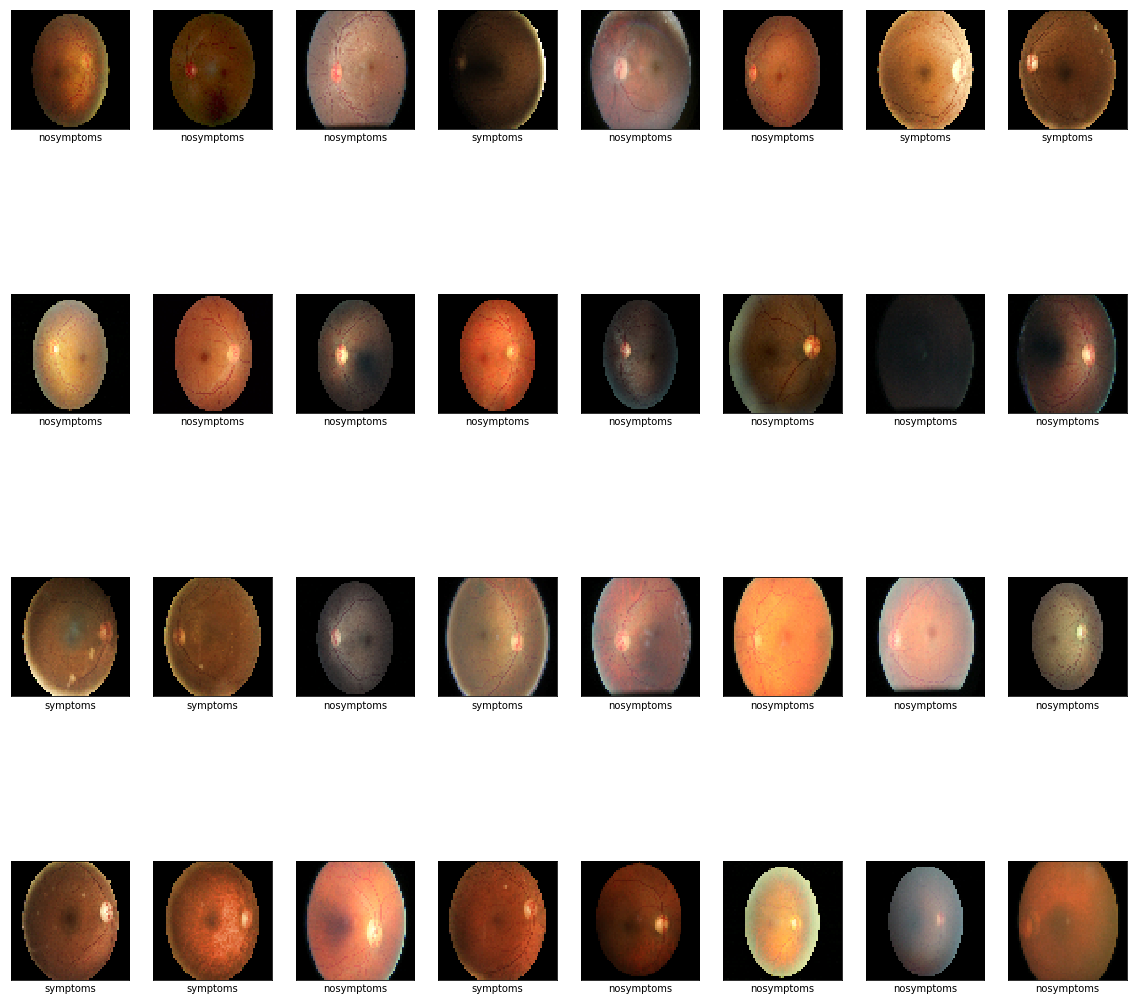

In [13]:
sample_training_values = []
sample_training_values.append('nosymptoms')
sample_training_values.append('symptoms')

plt.figure(figsize=(20,20))
for i in range(batch_size):
    plt.subplot(4,batch_size/4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(example[i], cmap=plt.cm.gray) #Per modalità b/w
    plt.imshow(sample_training_images[i], cmap=plt.cm.binary) #Per modalità RGB
    plt.xlabel(sample_training_values[int(sample_training_labels[i])])
plt.show()


# Data Augmentation
*Noto che le foto sono tra loro molto diverse per esposizione, colore, zoom etc. Per prevenire overfitting e "normalizzare" i dati andremo a creare duplicati delle immagini di **train** applicando trasformazioni di zoom, colore, esposizione etc. Le immagini di validation sono già pronte*

*Mantengo comunque due data set separati in modo da analizzare poi le differenze di performance*

*Genero il nuovo trasformatore*

In [29]:
#ImageDataGenerator()


aug_train_image_generator = ImageDataGenerator(
    #brightness_range = (0.5,1.5), #1 è no brightness change
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    rotation_range = 40,
    zoom_range = 0.2,
    horizontal_flip=True,
    rescale = 1./255)

#aug_train_image_generator.fit(sample_training_images) #se uso featurewise_center/std

*Trasformo le immagini*

In [30]:
aug_train_data_gen = aug_train_image_generator.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    #shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    #color_mode='grayscale', #Per b/w
    class_mode='binary')
    

Found 1650 images belonging to 2 classes.


*Creo un batch da (batch_size) esempi e le plotto*

In [31]:
print(aug_train_data_gen)
aug_sample_training_images, aug_sample_training_labels = next(aug_train_data_gen) #next prende (batch_size) elementi dell'iteratore train_data_gen (immagini -> s_tr_imgs) con relative labels (s_tr_lbls)
aug_sample_training_images.shape

(32, 64, 64, 3)

In [32]:
mean(aug_sample_training_labels)

0.25

## ----Routine B/W----

In [19]:
aug_sample_training_imagez = []

for i in range(batch_size):
    aug_sample_training_imagez.append(reshape(aug_sample_training_images[i],(IMG_HEIGHT,IMG_WIDTH)))

ValueError: cannot reshape array of size 12288 into shape (64,64)

In [ ]:
aug_example = array(aug_sample_training_imagez)

In [ ]:
aug_example.shape

## ----End Routine B/W----

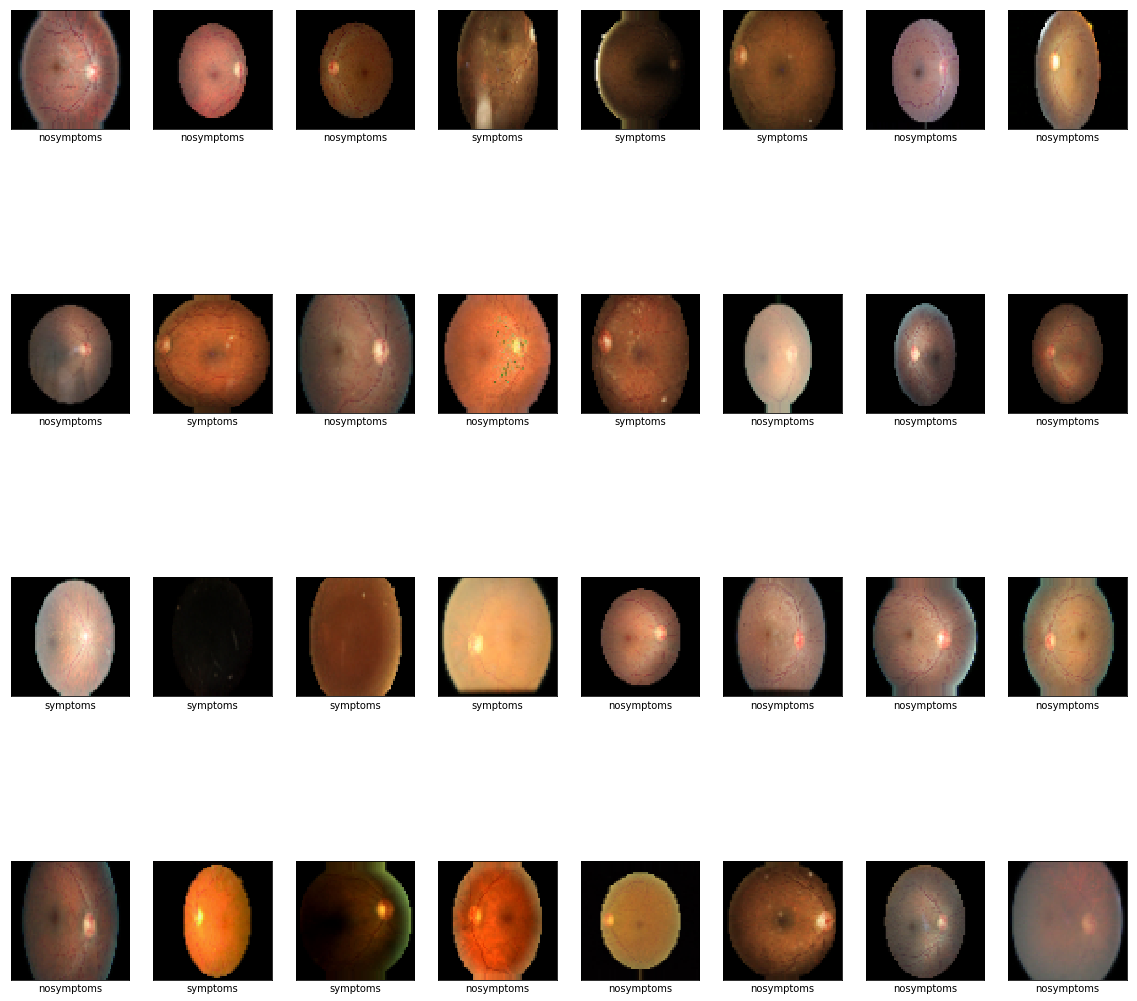

In [18]:
plt.figure(figsize=(20,20))
for i in range(batch_size):
    plt.subplot(4,batch_size/4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(aug_example[i], cmap=plt.cm.gray) #cmap=plt.cm.binary
    plt.imshow(aug_sample_training_images[i], cmap=plt.cm.binary) #Per modalità RGB

    plt.xlabel(sample_training_values[int(aug_sample_training_labels[i])])
plt.show()

# Building CNN

In [19]:
len(val_data_gen)

13

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping

#Dropout è regolarizzazione
#Flatten trasforma in 1-d per Dense
#Conv2D processa i dati dell'immagine Conv2D(noutput,(altezza,larghezza),...)
#MaxPooling2D riduce l'output space di Conv2D
#GlobalAvgPool pure

*Definisco callback di early stopping*

In [21]:
E_S = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

*Definisco alcune quantità utili e il modello base*

In [22]:
n_classes = 1
sgd = SGD(lr=0.0001)
adam = Adam(lr=0.01)
tot_train = num_nosympt_train + num_sympt_train
tot_validation = num_nosympt_validation + num_sympt_validation
steps = ceil(tot_train / batch_size)
val_steps = ceil(tot_validation / batch_size)
epochs = 20

Instructions for updating:
Colocations handled automatically by placer.


In [23]:
#Stack layers
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, channels), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Convolution2D(64, (3, 3), activation='relu'))
#model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
model.add(Dense(128, activation='relu'))
#model.add(Dense(50, activation='relu'))
model.add(Dense(n_classes, activation='sigmoid'))

#Compile model
model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 27,841
Trainable params: 27,841
Non-trainable params: 0
_________________________________________________________________


## Test the model on non augmented data

In [25]:
#model.fit_generator()
# Fit the model
history = model.fit_generator(
    train_data_gen,
    epochs=epochs,
    steps_per_epoch=steps,
    #use_multiprocessing = True,
    #workers = 8,
    #callbacks=[E_S], #EarlyStopping
    validation_data=val_data_gen,
    validation_steps=val_steps)
    



Instructions for updating:
Use tf.cast instead.
Epoch 1/20
52/52 [==============================] - 249s 5s/step - loss: 0.5779 - acc: 0.7121 - val_loss: 0.4956 - val_acc: 0.7312
Epoch 2/20
52/52 [==============================] - 220s 4s/step - loss: 0.5724 - acc: 0.7255 - val_loss: 0.5220 - val_acc: 0.7167
Epoch 3/20
52/52 [==============================] - 214s 4s/step - loss: 0.5533 - acc: 0.7261 - val_loss: 0.4867 - val_acc: 0.7530
Epoch 4/20
52/52 [==============================] - 212s 4s/step - loss: 0.5531 - acc: 0.7224 - val_loss: 0.5045 - val_acc: 0.7288
Epoch 5/20
52/52 [==============================] - 212s 4s/step - loss: 0.5542 - acc: 0.7261 - val_loss: 0.4879 - val_acc: 0.7651
Epoch 6/20
52/52 [==============================] - 206s 4s/step - loss: 0.5502 - acc: 0.7285 - val_loss: 0.4873 - val_acc: 0.7554
Epoch 7/20
52/52 [==============================] - 205s 4s/step - loss: 0.5490 - acc: 0.7242 - val_loss: 0.4910 - val_acc: 0.7530
Epoch 8/20
52/52 [=================

*Plot the results*

In [26]:
#history.history

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss=history.history['loss']
val_loss=history.history['val_loss']

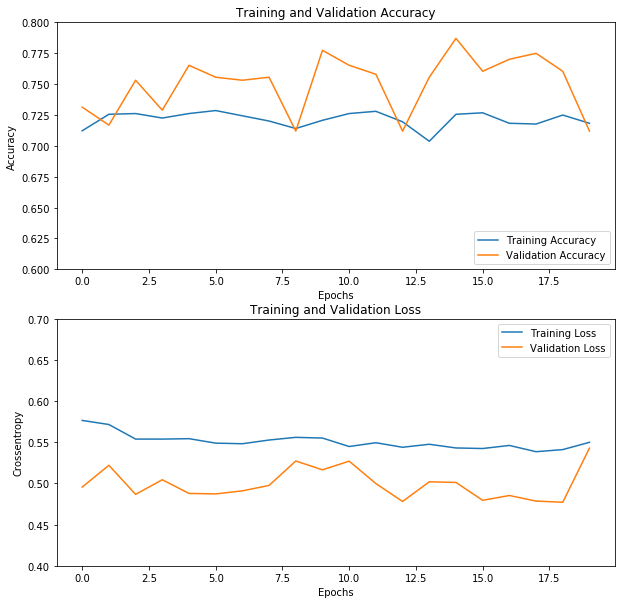

In [28]:


epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(.6, .8)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Crossentropy')
plt.ylim(0.4, .7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Test model on augmented data

In [33]:
#Stack layers
model1 = Sequential()
model1.add(Convolution2D(32, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, channels), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2))) 
model1.add(Convolution2D(64, (3, 3), activation='relu'))
#model1.add(Dropout(0.2))
model1.add(GlobalAveragePooling2D())
#model1.add(MaxPooling2D(pool_size=(2, 2)))
#model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
#model1.add(Dense(50, activation='relu'))
model1.add(Dense(n_classes, activation='sigmoid'))

#Compile model
model1.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [34]:
aug_history = model1.fit_generator(
    aug_train_data_gen,
    validation_data=val_data_gen,
    validation_steps=val_steps,
    steps_per_epoch=steps,
    #callbacks=[E_S], #EarlyStopping
    epochs=epochs)

Epoch 1/20
52/52 [==============================] - 219s 4s/step - loss: 0.6213 - acc: 0.7115 - val_loss: 0.6155 - val_acc: 0.7119
Epoch 2/20
52/52 [==============================] - 169s 3s/step - loss: 0.6012 - acc: 0.7115 - val_loss: 0.6076 - val_acc: 0.7119
Epoch 3/20
52/52 [==============================] - 169s 3s/step - loss: 0.6005 - acc: 0.7115 - val_loss: 0.6061 - val_acc: 0.7119
Epoch 4/20
52/52 [==============================] - 168s 3s/step - loss: 0.6015 - acc: 0.7115 - val_loss: 0.6138 - val_acc: 0.7119
Epoch 5/20
52/52 [==============================] - 168s 3s/step - loss: 0.6047 - acc: 0.7115 - val_loss: 0.6051 - val_acc: 0.7119
Epoch 6/20
52/52 [==============================] - 166s 3s/step - loss: 0.6029 - acc: 0.7115 - val_loss: 0.6051 - val_acc: 0.7119
Epoch 7/20
52/52 [==============================] - 167s 3s/step - loss: 0.6018 - acc: 0.7115 - val_loss: 0.6051 - val_acc: 0.7119
Epoch 8/20
52/52 [==============================] - 169s 3s/step - loss: 0.6039 - a

*Plotto i dati*

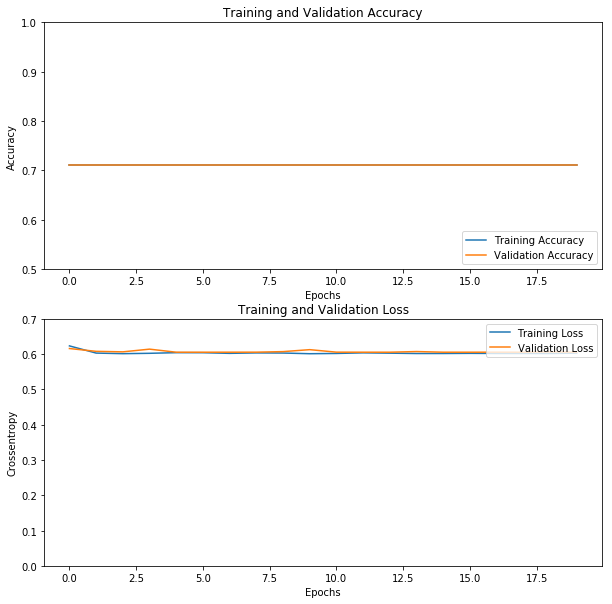

In [35]:
acc = aug_history.history['acc']
val_acc = aug_history.history['val_acc']

loss=aug_history.history['loss']
val_loss=aug_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(.5, 1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Crossentropy')
plt.ylim(0, .7)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Noto che i valori di accuracy relativi sia al set di training che al set di validation riproducono esattamente le frequenze con la quale nei due diversi dataset occorrono gli occhi sani. Credo che la rete stia classificando tutti gli occhi come sani indipendentemente dall'immagine in input. Questo probabilmente è dovuto sia al fatto che i dati di training sono decisamente pochi (soprattutto se comparati al numero di gradi di libertà del modello testato) sia al fatto che non abbiamo usato una distribuzione di dati uniforme sulle due classi. L'obbiettivo di questo studio iniziale in ogni caso non era realizzare un modello performante quanto vedere che la processazione dei dati in input fosse fatta in maniera consona e provare a giocare con le varie opzioni a disposizione.* 